<a href="https://colab.research.google.com/github/ConanOReilly/Final_Year_Project/blob/main/Image_Data/SwinTinySingleInput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Swin-Tiny WnB Model**
Used this out going, single input model from Weights and Balances, originally trained on the HAM 10000 dataset, to see if performance can be imroved from the addition of metadata, testing increasingly complex methods on how to concatenate metadata.

Model: https://wandb.ai/byyoung3/ml-news/reports/Skin-Lesion-Classification-on-HAM10000-with-HuggingFace-using-PyTorch-and-W-B--Vmlldzo2NTIyMTc3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import os
import random
import datetime
import pandas as pd
import numpy as np
from PIL import Image, UnidentifiedImageError
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import Swinv2Model
from torch.optim import Adam

# **Defining Dataset, Classes, Weights, and Model**

In [ ]:
class PADUFESDataset(Dataset):
    def __init__(self, csv_file, img_dir, augment=True):
        self.skin_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.augment = augment

        self.label_dict = {label: idx for idx, label in enumerate(sorted(self.skin_df['diagnostic'].unique()))}
        self.skin_df['label_encoded'] = self.skin_df['diagnostic'].map(self.label_dict)


        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

        self.base_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.skin_df)

    def __getitem__(self, idx):
        attempts = 0
        max_attempts = 100
        while attempts < max_attempts:
            try:
                row = self.skin_df.iloc[idx]
                img_path = os.path.join(self.img_dir, row['img_id'])
                image = Image.open(img_path).convert("RGB")
                image = self.transform(image) if self.augment else self.base_transform(image)
                label = row['label_encoded']
                return image, label
            except (FileNotFoundError, UnidentifiedImageError):
                attempts += 1
                idx = random.randint(0, len(self.skin_df) - 1)
        raise Exception(f"Failed to load image after {max_attempts} attempts.")

In [ ]:
def make_weights_for_balanced_classes(dataset):
    class_counts = dataset.skin_df['label_encoded'].value_counts()
    num_samples = len(dataset)
    class_weights = {i: num_samples / class_counts[i] for i in range(len(class_counts))}
    weights = [class_weights[label] for label in dataset.skin_df['label_encoded']]
    return weights

In [ ]:
class SwinV2Classifier(nn.Module):
    def __init__(self, num_classes):
        super(SwinV2Classifier, self).__init__()
        self.model = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
        self.classifier = nn.Linear(self.model.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.model(x)
        return self.classifier(outputs.pooler_output)

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(train_loader), correct / total


def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / len(val_loader), correct / total, all_preds, all_labels

In [ ]:
# Paths
train_csv = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_folders.csv"
test_csv = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_test.csv"
img_dir = "/content/drive/MyDrive/Final Year Project/Data/PAD/imgs"
save_path = "/content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_single_input.pth"

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Datasets
train_ds = PADUFESDataset(train_csv, img_dir, augment=True)
test_ds = PADUFESDataset(test_csv, img_dir, augment=False)

In [ ]:
# Sampler
weights = make_weights_for_balanced_classes(train_ds)
sampler = WeightedRandomSampler(weights, len(weights))

In [ ]:
# Loaders
train_loader = DataLoader(train_ds, batch_size=12, sampler=sampler)
test_loader = DataLoader(test_ds, batch_size=12)

In [ ]:
# Model
model = SwinV2Classifier(num_classes=len(train_ds.label_dict)).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [ ]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=3e-6)
epochs = 20
best_val_acc = 0.0
class_names = [label for label, idx in sorted(train_ds.label_dict.items(), key=lambda x: x[1])]

# **Trainig Model**

In [ ]:
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model to {save_path}")

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Epoch 1: Train Loss=1.7028, Val Loss=1.5386, Val Acc=0.5300
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_single_input.pth
Epoch 2: Train Loss=1.2727, Val Loss=1.1600, Val Acc=0.5770
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_single_input.pth
Epoch 3: Train Loss=0.9272, Val Loss=0.9638, Val Acc=0.6188
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_single_input.pth
Epoch 4: Train Loss=0.7661, Val Loss=0.9348, Val Acc=0.6057
Epoch 5: Train Loss=0.6873, Val Loss=0.8635, Val Acc=0.6710
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_single_input.pth
Epoch 6: Train Loss=0.6367, Val Loss=0.8757, Val Acc=0.6580
Epoch 7: Train Loss=0.5919, Val Loss=0.8270, Val Acc=0.6658
Epoch 8: Train Loss=0.5420, 

# **Evaluation**

Classification Report:
               precision    recall  f1-score   support

         ACK       0.80      0.75      0.78       122
         BCC       0.77      0.75      0.76       141
         MEL       0.78      0.78      0.78         9
         NEV       0.74      0.78      0.76        40
         SCC       0.35      0.47      0.40        32
         SEK       0.81      0.74      0.77        39

    accuracy                           0.73       383
   macro avg       0.71      0.71      0.71       383
weighted avg       0.74      0.73      0.74       383



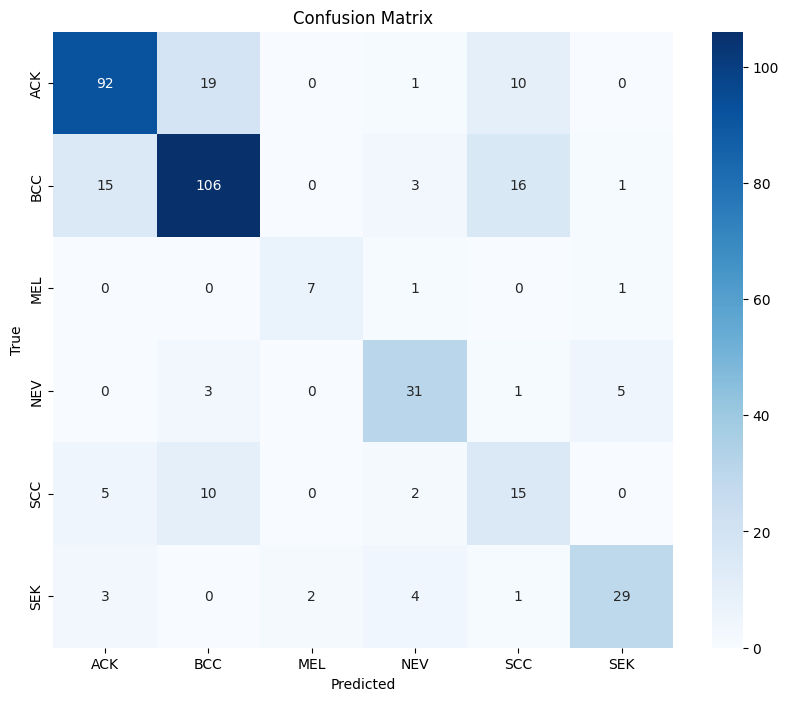

In [ ]:
# Final evaluation
val_loss, val_acc, preds, labels = evaluate(model, test_loader, criterion, device)
print("Classification Report:\n", classification_report(labels, preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()